In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder



In [23]:
import nltk
nltk.download('punkt_tab')  # This downloads the 'punkt' tokenizer models, including punkt_tab

nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# Step 1: Load and preprocess dataset
df = pd.read_csv("/content/climate_nasa (1).csv")

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'text'])  # Drop rows with null date or text

# Optional: clean user names and missing values
df.fillna({'likesCount': 0, 'commentsCount': 0, 'profileName': 'Unknown'}, inplace=True)


In [25]:
# Step 2: Create sentiment labels manually (for ML training)
# You can label a subset of data or simulate with rule-based method
def label_sentiment(text):
    from textblob import TextBlob
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['text'].apply(label_sentiment)

In [40]:
df.head()

,date,likesCount,profileName,commentsCount,text,sentiment_label,clean_text,predicted_sentiment,month,engagement
0,2022-09-07 17:12:32+00:00,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,0.0,Neat comparison I have not heard it before.\n ...,neutral,neat comparison heard would say like disco bal...,neutral,2022-09,2.0
1,2022-09-08 14:51:13+00:00,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,0.0,An excellent way to visualise the invisible! T...,positive,excellent way visualise invisible thanks,positive,2022-09,0.0
2,2022-09-07 17:19:41+00:00,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...,neutral,troposphere affect stratosphere warmer troposp...,neutral,2022-09,4.0
3,2022-09-08 00:51:30+00:00,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,0.0,excellent post! I defo feel the difference - o...,neutral,excellent post defo feel difference one drink ...,neutral,2022-09,4.0
4,2022-09-07 19:06:20+00:00,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart...",negative,yes carbon dioxide harm earth like people maki...,negative,2022-09,42.0


In [26]:
# Step 3: Preprocess text
def clean_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)


In [27]:
df['clean_text'] = df['text'].astype(str).apply(clean_text)

In [29]:
# Step 4: Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=3000)
X_text = vectorizer.fit_transform(df['clean_text'])

In [30]:
# Step 5: Combine with numeric features
X_numeric = df[['likesCount', 'commentsCount']]
X_all = np.hstack([X_text.toarray(), X_numeric.values])


In [31]:
# Step 6: Label encode the sentiment
le = LabelEncoder()
y = le.fit_transform(df['sentiment_label'])


In [32]:
# Step 7: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

In [33]:
# Step 8: Train ML model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [44]:
# Step 9: Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 63.366336633663366
              precision    recall  f1-score   support

    negative       1.00      0.08      0.14        13
     neutral       0.62      0.98      0.76        60
    positive       0.80      0.14      0.24        28

    accuracy                           0.63       101
   macro avg       0.81      0.40      0.38       101
weighted avg       0.72      0.63      0.54       101



In [39]:
X_all

array([[ 0.,  0.,  0., ...,  0.,  2.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  3.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  3.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., 12.,  1.]])

In [35]:
# Step 10: Apply model to all data for visualization
df['predicted_sentiment'] = le.inverse_transform(model.predict(X_all))


/tmp/ipython-input-3202170641.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')


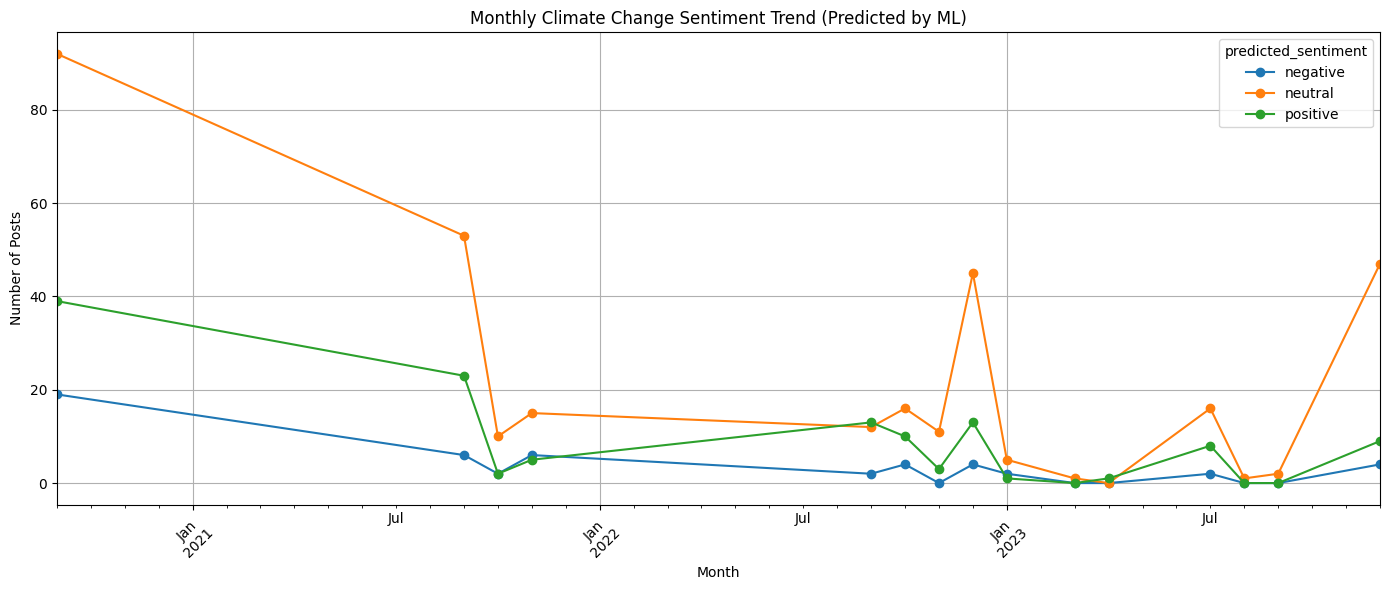

In [36]:
# Step 11: Trend Visualization
df['month'] = df['date'].dt.to_period('M')
monthly_sentiment = df.groupby(['month', 'predicted_sentiment']).size().unstack().fillna(0)

monthly_sentiment.plot(figsize=(14,6), marker='o')
plt.title("Monthly Climate Change Sentiment Trend (Predicted by ML)")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Step 12: Analyze High Engagement Posts
df['engagement'] = df['likesCount'] + df['commentsCount']
top_engaged = df.sort_values(by='engagement', ascending=False).head(20)

print("Top 5 Engaging Posts:")
print(top_engaged[['date', 'profileName', 'text', 'engagement', 'predicted_sentiment']].head(5))



Top 5 Engaging Posts:
                         date  \
397 2021-11-01 15:42:25+00:00   
433 2022-12-22 18:12:11+00:00   
427 2021-10-31 19:15:08+00:00   
126 2021-09-22 22:11:46+00:00   
204 2021-09-23 02:04:13+00:00   

                                           profileName  \
397  99459d1c18c5166316e5546a6f29c49a7fdfbec7b95d89...   
433  e0d27ee7aba5366ee0cfa5b8b0c1f60551d805c253d46d...   
427  1c544111b75e56596f09053397579f1724dcd7b1ae96f5...   
126  b1efe19dbac95ba7af0e7706446b060fb04a43e2f32a1c...   
204  d223bdbdb300829620b28e11d723bf6053bbc3cb334e79...   

                                                  text  engagement  \
397  You are being gas-lighted. Have any of you hea...       192.0   
433  I can only hope to someday attain the level of...       140.0   
427  Too bad we don’t see Oct 1821 or 1721, just ke...       114.0   
126  I love watch NASA dunk on people who think the...       113.0   
204  Blah blah blah. There is nothing man can do to...        99.0   

    predi

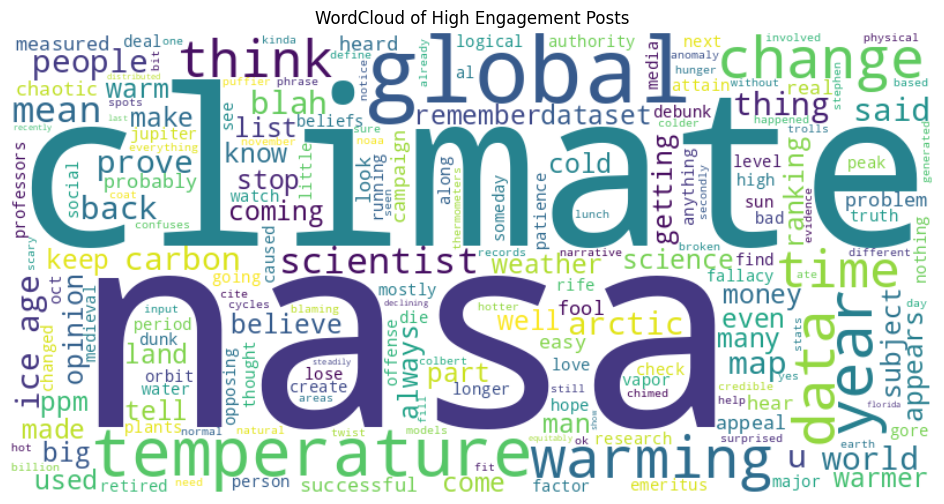

In [38]:
# WordCloud for high-engagement posts
wc_text = ' '.join(top_engaged['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of High Engagement Posts')
plt.show()


In [47]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump( vectorizer,'Vector.pkl')

['Vector.pkl']